# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-lc'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=192, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(least_confident_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5939, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5228, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1597, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1896, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4377, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1376, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1528, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.1231, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6518
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2046, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.653
Epoch 10/10, Train Loss: 0.091, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.1228, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1009, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3431, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9696, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3403, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8201
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8198
Epoch 10/10, Train Loss: 0.0438, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.294, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7992
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2989, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.033, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3033, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0597, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Iteration 265: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2965, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7548
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7995
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9615, F1 Micro: 0.971, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3054, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1988, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7821
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7743
Iteration 292: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2764, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8177
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7864
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7854
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2976, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8005
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7476
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9615, F1 Micro: 0.9708, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1548, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7327
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.802
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.9696, F1 Micro: 0.9768, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1636, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7555
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9615, F1 Micro: 0.9709, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2603, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1555, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7731
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9679, F1 Micro: 0.9756, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1485, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7175
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7868
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7557
Iteration 360: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2455, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.142, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0443, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0286, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.25, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 5/10, Train Loss: 0.0866, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 6/10, Train Loss: 0.0584, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.041, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7484
Iteration 380: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 5/10, Train Loss: 0.0951, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7439
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7861
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7576
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7567
Iteration 390: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1682, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7611
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7549
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7431
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Iteration 400: Accuracy: 0.9679, F1 Micro: 0.9756,

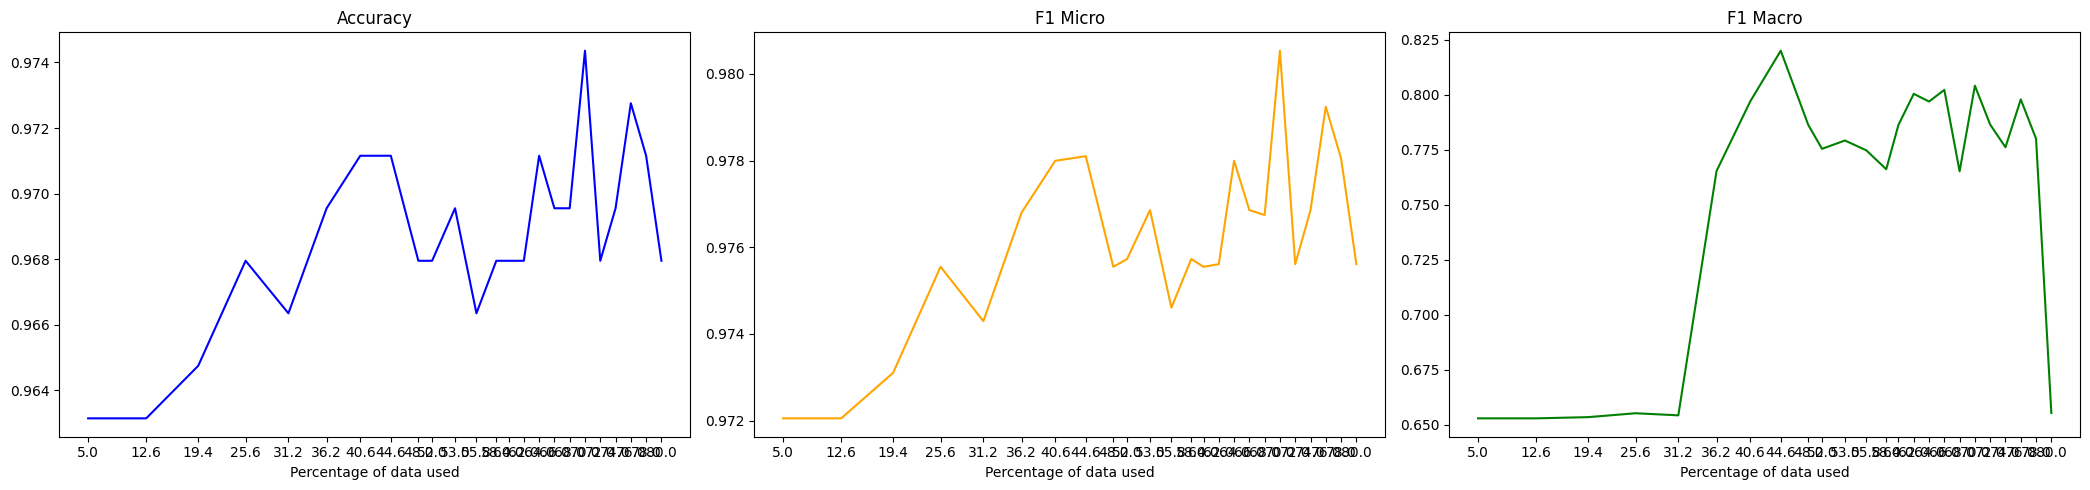

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6189, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.34, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2964, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.219, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1669, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1941, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1938, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.1249, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.1101, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1961, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0873, Accuracy: 0.9535, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2073, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.7591
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9647, F1 Micro: 0.9734, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3483, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0543, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7971
Epoch 10/10, Train Loss: 0.0322, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3392, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1573, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0489, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3086, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.194, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9696, F1 Micro: 0.9769, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1972, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1971, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Iteration 265: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3045, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1911, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8217
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7538
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.041, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2838, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8186
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0805, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7491
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7585
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9663, F1 Micro: 0.9745, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2774, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7584
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7882
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2977, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1943, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 5/10, Train Loss: 0.1026, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.755
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 10/10, Train Loss: 0.0241, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Iteration 310: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2736, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1798, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.13, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7939
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7393
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.7966
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1727, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7451
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7741
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Iteration 330: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2616, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1296, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.059, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7966
Epoch 7/10, Train Loss: 0.0481, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7433
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0195, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2651, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.192, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1253, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.8212
Epoch 5/10, Train Loss: 0.0902, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.0554, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8042
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0273, Accuracy: 0.9696, F1 Micro: 0.977, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2464, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.0893, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7402
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1268, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7733
Epoch 5/10, Train Loss: 0.0722, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7754
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7483
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7461
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8002
Iteration 370: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2628, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7927
Epoch 6/10, Train Loss: 0.0667, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1479, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0871, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7748
Epoch 6/10, Train Loss: 0.0669, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7934
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0209, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.173, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1347, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Epoch 4/10, Train Loss: 0.104, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0692, Accuracy: 0.9776, F1 Micro: 0.9829, F1 Macro: 0.8235
Epoch 6/10, Train Loss: 0.0604, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.805
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7743
Epoch 10/10, Train Loss: 0.0163, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7576
Iteration 400: Accurac

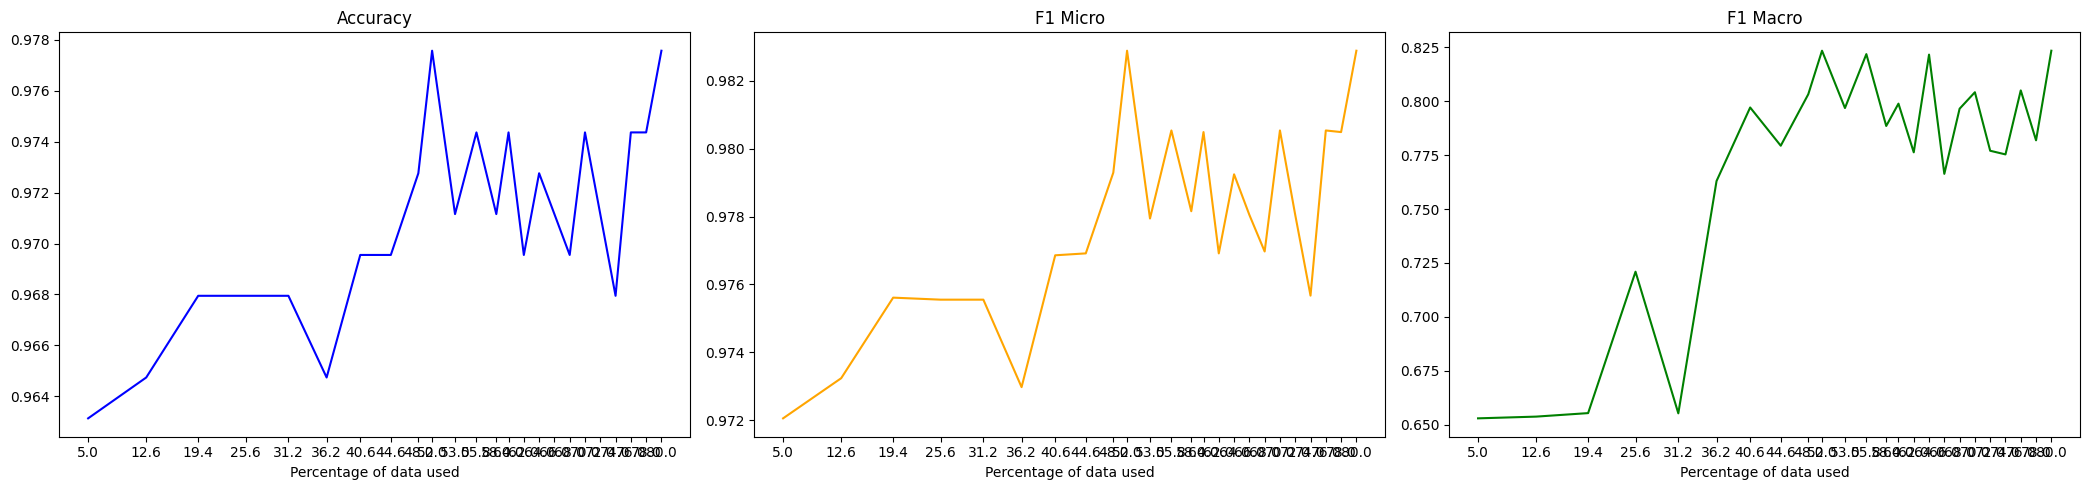

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2471, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4779, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1787, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1637, Accuracy: 0.9631, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3816, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.6463
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9503, F1 Micro: 0.9616, F1 Macro: 0.6442
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9535, F1 Micro: 0.964, F1 Macro: 0.6459
Epoch 8/10, Train Loss: 0.1315, Accuracy: 0.9551, F1 Micro: 0.9652, F1 Macro: 0.6467
Epoch 9/10, Train Loss: 0.0937, Accuracy: 0.9519, F1 Micro: 0.9626, F1 Macro: 0.6445
Epoch 10/10, Train Loss: 0.0865, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.6499
Iteration 97: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2193, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.6465
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9375, F1 Micro: 0.9506, F1 Macro: 0.6334
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.9167, F1 Micro: 0.9328, F1 Macro: 0.6149
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.9439, F1 Micro: 0.956, F1 Macro: 0.6386
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9551, F1 Micro: 0.9652, F1 Macro: 0.6467
Epoch 10/10, Train Loss: 0.0765, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Iteration 128: Accuracy: 0.9631, F1 Micro: 0.9721, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9423, F1 Micro: 0.9548, F1 Macro: 0.6377
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9535, F1 Micro: 0.9639, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1252, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6469
Epoch 10/10, Train Loss: 0.0625, Accuracy: 0.9599, F1 Micro: 0.969, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3321, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2006, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0489, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3041, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6488
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9487, F1 Micro: 0.96, F1 Macro: 0.6423
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9407, F1 Micro: 0.9532, F1 Macro: 0.6358
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9487, F1 Micro: 0.9597, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9583, F1 Micro: 0.9677, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3052, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2008, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9519, F1 Micro: 0.9625, F1 Macro: 0.6443
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.791
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.8212
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.9712, F1 Micro: 0.9781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2763, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9519, F1 Micro: 0.9625, F1 Macro: 0.7532
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6515
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7369
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9551, F1 Micro: 0.9655, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.7478
Iteration 241: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2857, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6505
Epoch 6/10, Train Loss: 0.0701, Accuracy: 0.9455, F1 Micro: 0.9573, F1 Macro: 0.6398
Epoch 7/10, Train Loss: 0.0459, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7835
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8381
Iteration 250: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.291, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1866, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7142
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.7688
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7835
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7734
Iteration 279: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1663, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.077, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7962
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8522
Epoch 10/10, Train Loss: 0.0313, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7932
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8776
Iteration 300: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.284, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1048, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7879
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.817
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7726
Epoch 8/10, Train Loss: 0.0425, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.82
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8845
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1881, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7985
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8034
Epoch 10/10, Train Loss: 0.0326, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1985, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7999
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0432, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7903
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7451
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7411
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Iteration 330: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2648, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1584, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0662, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8217
Epoch 7/10, Train Loss: 0.0432, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 4/10, Train Loss: 0.1268, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.1003, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7982
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8189
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8227
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8179
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9712, F1 Micro: 0.9781, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.243, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.162, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1144, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0862, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 6/10, Train Loss: 0.0542, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8197
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.7595
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9535, F1 Micro: 0.9643, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2203, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1589, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1067, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7611
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7855
Iteration 370: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2532, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0894, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7215
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.7895
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2441, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1445, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Iteration 390: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1681, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1177, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0667, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7861
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7646
Epoch 10/10, Train Loss: 0.0206, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7755
Iteration 400: Accu

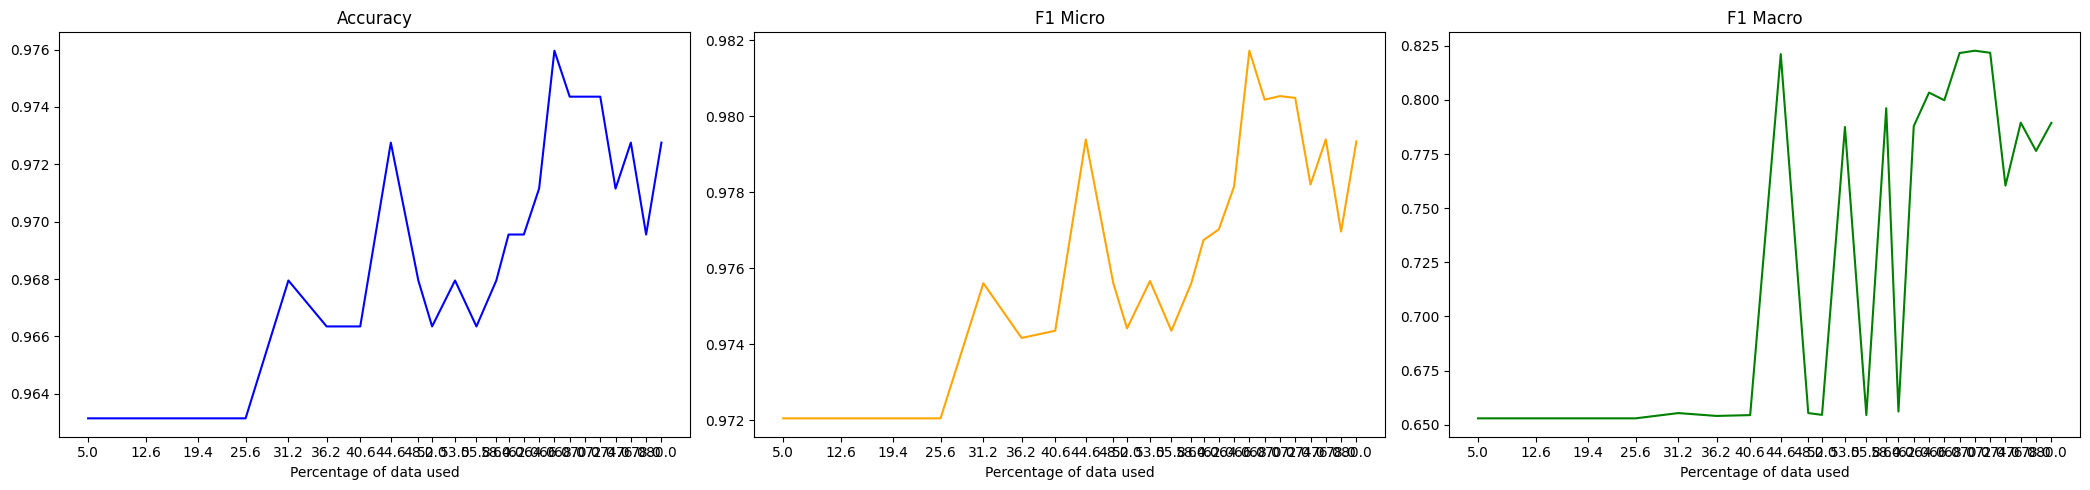

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1755, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1676, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2216, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2181, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1925, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1948, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.1607, Accuracy: 0.9599, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2159, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1152, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0984, Accuracy: 0.9615, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3474, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7956
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7648
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2023, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1596, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3051, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9599, F1 Micro: 0.97, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7552
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7529
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7538
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7539
Iteration 181: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3097, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2093, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7571
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7474
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7844
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8986
Epoch 10/10, Train Loss: 0.0359, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2916, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2009, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7966
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9535, F1 Micro: 0.9646, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8186
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7471
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8002
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7744
Iteration 223: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2067, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7655
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8023
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7486
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9615, F1 Micro: 0.9708, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2796, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7958
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7494
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7864
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8012
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.9663, F1 Micro: 0.9744, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2039, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7632
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7481
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7752
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2778, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9599, F1 Micro: 0.97, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8208
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8669
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8612
Iteration 279: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7557
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2027, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7862
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7646
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7633
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7857
Epoch 8/10, Train Loss: 0.0444, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.03, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7867
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7632
Iteration 300: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7783
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9535, F1 Micro: 0.9647, F1 Macro: 0.7389
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7486
Iteration 310: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7966
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7379
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7919
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7536
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7514
Iteration 320: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2455, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.764
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9567, F1 Micro: 0.9666, F1 Macro: 0.758
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7823
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0249, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7958
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0832, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7555
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0227, Accuracy: 0.9615, F1 Micro: 0.971, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1427, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7537
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7536
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.757
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7546
Epoch 10/10, Train Loss: 0.0206, Accuracy: 0.9647, F1 Micro: 0.9734, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7421
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.7236
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7367
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.8415
Epoch 10/10, Train Loss: 0.0185, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.8349
Iteration 360: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9728, F1 Micro: 0.9794, F1 Macro: 0.8035
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7879
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7316
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7503
Epoch 8/10, Train Loss: 0.0258, Accuracy: 0.9679, F1 Micro: 0.9759, F1 Macro: 0.8624
Epoch 9/10, Train Loss: 0.0208, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.8613
Epoch 10/10, Train Loss: 0.0181, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7653
Iteration 370: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2335, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8189
Epoch 5/10, Train Loss: 0.0921, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0414, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.8598
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8437
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8159
Epoch 10/10, Train Loss: 0.0182, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.8606
Iteration 380: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2346, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1682, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0858, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8204
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7466
Epoch 7/10, Train Loss: 0.0409, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8667
Epoch 8/10, Train Loss: 0.0299, Accuracy: 0.9567, F1 Micro: 0.9675, F1 Macro: 0.7423
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.8521
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9663, F1 Micro: 0.9747, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2225, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1382, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7958
Epoch 4/10, Train Loss: 0.1228, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7571
Epoch 5/10, Train Loss: 0.0921, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7524
Epoch 7/10, Train Loss: 0.0474, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 10/10, Train Loss: 0.02, Accuracy: 0.9679, F1 Micro: 0.9759, F1 Macro: 0.8616
Iteration 400: Accur

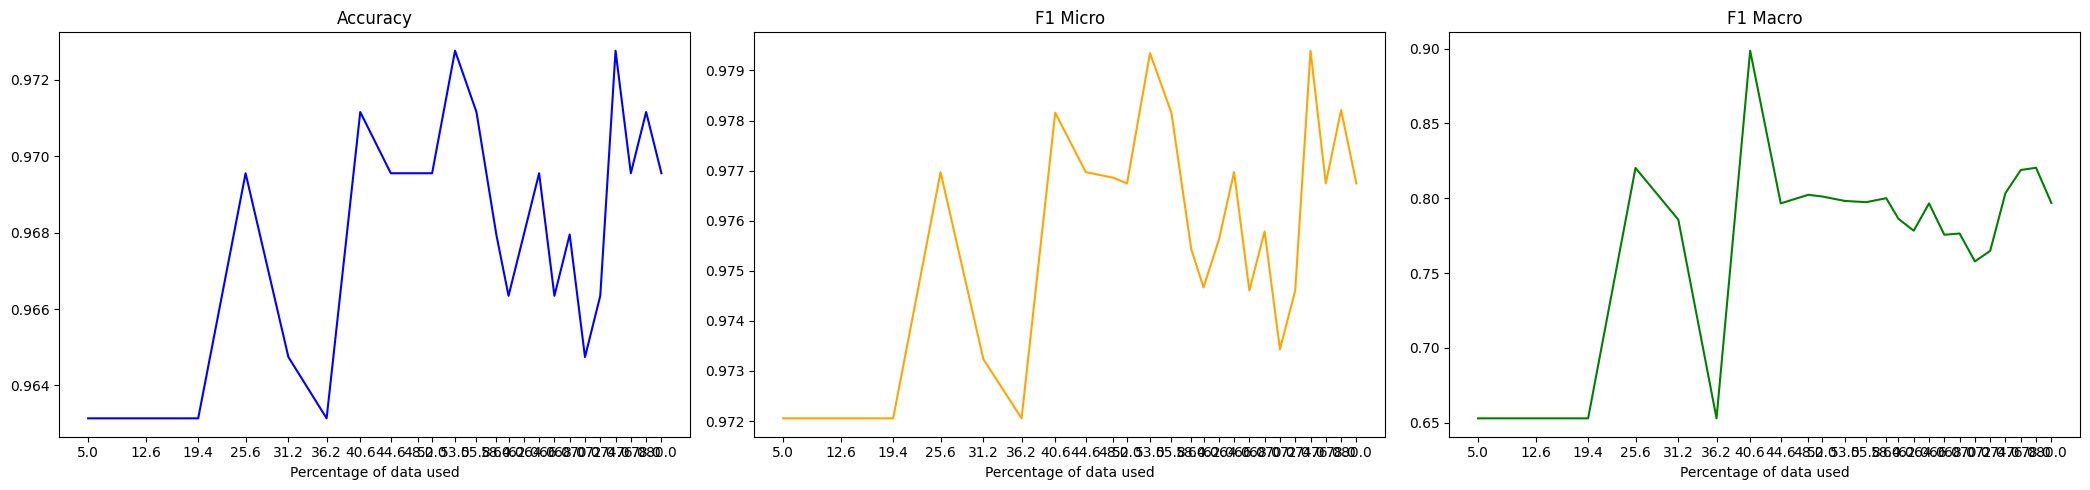

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3322, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2659, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2083, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2039, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1697, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.197, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4762, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2122, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1311, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2005, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0465, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9647, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3112, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1587, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6549
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9679, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1547, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9631, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1548, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0318, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1545, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8008
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7952
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.786
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9615, F1 Micro: 0.971, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2726, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7862
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0334, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2667, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0999, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0844, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8208
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9631, F1 Micro: 0.9722, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1812, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0787, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8196
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7858
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Iteration 292: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7858
Epoch 6/10, Train Loss: 0.0574, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0281, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2695, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7551
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7477
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7734
Iteration 310: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2664, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7771
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7552
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1768, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 6/10, Train Loss: 0.0716, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7412
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7748
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0233, Accuracy: 0.9583, F1 Micro: 0.9686, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.257, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1594, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7877
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7432
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7495
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7423
Epoch 10/10, Train Loss: 0.0229, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2595, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1683, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8217
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0246, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2382, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0564, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8013
Epoch 7/10, Train Loss: 0.0477, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7868
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0184, Accuracy: 0.9663, F1 Micro: 0.9745, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7568
Iteration 370: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2294, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7528
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Epoch 6/10, Train Loss: 0.0657, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7536
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7617
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Iteration 380: Accuracy: 0.9696, F1 Micro: 0.9767, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2493, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.0309, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0184, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Iteration 390: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2201, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1487, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7747
Epoch 5/10, Train Loss: 0.0919, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.0592, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 9/10, Train Loss: 0.0218, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7549
Epoch 10/10, Train Loss: 0.0211, Accuracy: 0.9615, F1 Micro: 0.971, F1 

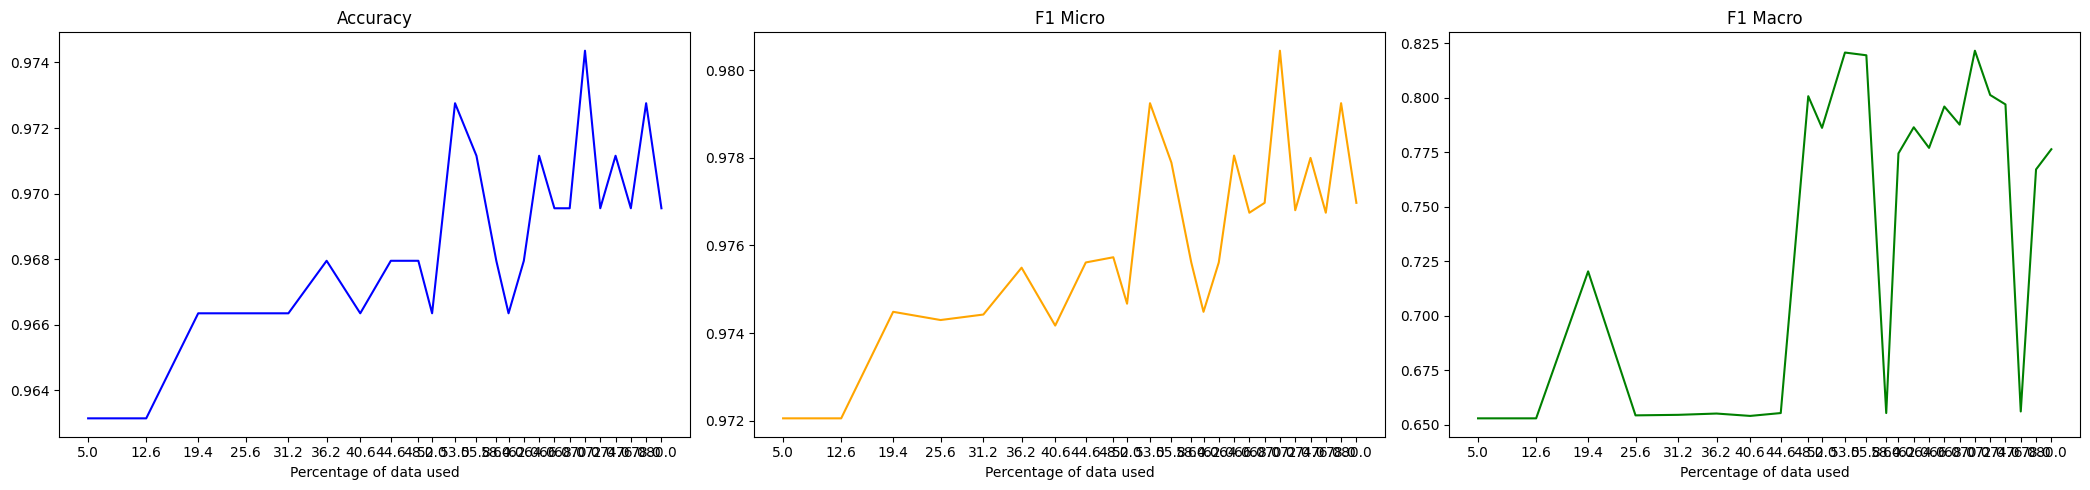

In [21]:
active_learning(seeds[4], 4)